In [ ]:
# default_exp engine.noise

In [ ]:
%load_ext autoreload
%autoreload 2

# Noise model

> Definition of the classes used to model the camera noise

In [ ]:
#export
from decode_fish.imports import *
from torch import nn
from torch import distributions as D
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *
import scipy.stats as stats  

In [ ]:
#export
class sCMOS(nn.Module):
    """
    Generates sCMOS noise distribution which can be used for sampling and
    calculating log probabilites.
    
    Theta can be learned (but no the baseline)

    Args:
        theta (float): 1/theta gives the rate for torch.distributions.gamma
        baseline (float): baseline

    """
    def __init__(self,
                 theta: float = 3.,
                 baseline: float = 0.,
                 channels: int = 0):
        super().__init__()
        
        if channels:
            self.theta_scale = theta * channels
            self.theta_par = torch.nn.Parameter(torch.ones(channels)/channels)
        else:
            self.theta_scale = theta 
            self.theta_par = torch.nn.Parameter(torch.tensor(1.))
            
        self.register_buffer('baseline', torch.tensor(baseline))
        self.channels = channels

    def forward(self, x_sim, background, ch_inds=[0]):
        """ Calculates the concentration (mean / theta) of a Gamma distribution given
        the signal x_sim and background tensors.
        Also applies a shift and returns resulting the Gamma distribution
        """
        
        x_sim_background = x_sim + background
        x_sim_background.clamp_(1.0 + self.baseline)
        
        if self.channels:
            theta = (self.theta_scale * self.theta_par)[ch_inds].reshape([1,len(ch_inds),1,1,1])
        else:
            theta = (self.theta_scale * self.theta_par)
        
        conc = (x_sim_background - self.baseline) / theta
        xsim_dist = D.Gamma(concentration=conc, rate=1 / theta)
        
        loc_trafo = [D.AffineTransform(loc=self.baseline, scale=1)]
        xsim_dist = D.TransformedDistribution(xsim_dist, loc_trafo)
        return xsim_dist

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.microscope import Microscope
from decode_fish.funcs.plotting import plot_3d_projections
from decode_fish.funcs.file_io import get_gaussian_psf

psf = get_gaussian_psf([21,21,21],[1.,1.,1.])
noise = sCMOS(theta=7., baseline=0, channels=12)

micro = Microscope(psf=psf, noise=noise, scale=1000).cuda()

point_process = PointProcessUniform(local_rate = torch.ones([1,12,48,48,48]).cuda()*.0001, channels=12)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)

background = torch.ones_like(xsim) * 500
xsim_noise = micro.noise(xsim, background, torch.arange(12)).sample()

In [ ]:
noise.theta_par

Parameter containing:
tensor(1., requires_grad=True)

In [ ]:
noise.theta_par.shape

torch.Size([1])

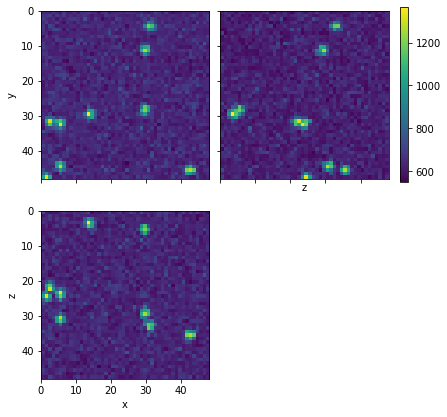

In [ ]:
_ = plot_3d_projections(xsim_noise[0,2], size=3)

In [ ]:
micro.noise(xsim,background).log_prob(xsim_noise).mean()

tensor(-5.4957, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
from decode_fish.funcs.dataset import EstimateBackground
# img = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_3.tif')
img = xsim_noise.cpu()
estimate_bg = EstimateBackground(smoothing_filter_size=5)
bg = estimate_bg(img)

ImportError: cannot import name 'EstimateBackground' from 'decode_fish.funcs.dataset' (/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/dataset.py)

In [ ]:
# export
def estimate_noise_scale(img, bg_est, percentile=99, plot=True):
    """ Returns an estimate of theta given a volume and a background estimate 
    
    Args:
        img: recorded volume for which we want to estimate the noise 
        bg_est: estimated background for img
        percentile: we wan't to exclude the signal for our fit. therefore we only use the lower percentile of all voxels
        plot: whether to plot the data and the final fit
        
    Returns:
        fit_theta: theta estimate
    """
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual < np.percentile(residual, percentile)]
    fit_alpha, fit_loc, fit_theta=stats.gamma.fit(fit_vals, floc=0)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_theta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_theta

6.94561330679186

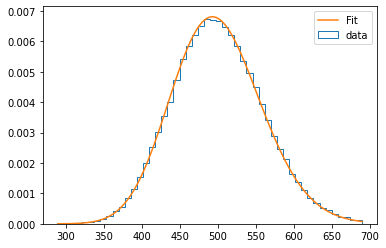

In [ ]:
estimate_noise_scale(img, bg, 99.5)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted MERFISH_routines.ipynb.
Converted index.ipynb.
